# Example: full information case, linear system
In the following example we analyse the utility-privacy trade-off for a simple linear system in the full information case. The system is described as follows
 
$$x_{t+1}=Ax_t+Ba_t +F\theta \mathbb{1}_{t\geq \nu} +w_t $$

where $w \sim \mathcal{N}(0, Q)$, with $Q=I_2$, $A=\begin{bmatrix}0 & 1\\1 & 1\end{bmatrix}$, $B=\begin{bmatrix}0.01\\1\end{bmatrix}$, $F=\begin{bmatrix}0.5 \\ 0.7\end{bmatrix}, \theta=1$.

The control law chosen by the user is $a_t=Kx_t + \beta_t$ where $\beta_t\sim\mathcal{N}(\alpha_0, R)$ for $t<\nu$ and $\beta_t\sim \mathcal{N}(\alpha_1, R)$ for $t\geq \nu$, where $R=1$. The control gain stabilizes the system, chosen as $K=\begin{bmatrix}-0.7 & -0.9\end{bmatrix}$.

In this example we investigate how to tune $(\alpha_0,\alpha_1)$ according to the utility-privacy value function.

In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
#
# Copyright (c) 2021 Alessio Russo [alessior@kth.se]. All rights reserved.
#
# This file is part of PrivacyStochasticSystems.
#
# PrivacyStochasticSystems is free software: you can redistribute it and/or modify
# it under the terms of the MIT License. You should have received a copy of
# the MIT License along with PrivacyStochasticSystems.
# If not, see <https://opensource.org/licenses/MIT>.
#

import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import scipy.signal as scipysig
from scipy.linalg import solve_discrete_lyapunov


## Figures parameters
plt.rcParams.update({
    "font.family": "serif",  # use serif/main font for text elements
    "text.usetex": True,  # use inline math for ticks
    "pgf.rcfonts": False,  # don't setup fonts from rc parameters
    "legend.fontsize": 14,
    "pgf.preamble": [
        "\\usepackage{units}",  # load additional packages
        "\\usepackage{metalogo}",
        "\\usepackage{unicode-math}",  # unicode math setup
        r"\setmathfont{xits-math.otf}",
        r"\setmainfont{DejaVu Serif}",  # serif font via preamble
    ],
    'figure.figsize': [16, 4],
    'figure.dpi': 100
})


/home/alessior/anaconda3/envs/PrivacyEnv/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


## System definition and parameters

In [3]:
# Dimensions
n = 2
m = 1

# System matrices
A = np.array([[0, 1], [1, 1]])
B = np.array([[0.01], [1]])
F = np.array([[0.5], [0.7]])
R = 0.1 * np.identity(m)
Q = np.identity(n)
theta = 1
K = np.array([[-0.7, -0.9]])


Qinv = np.linalg.inv(Q)
Rinv = np.linalg.inv(R)
L = np.identity(n) - A - B @ K
E = np.linalg.inv(L).T @ np.linalg.inv(L)
Sigma = solve_discrete_lyapunov((A + B@K), Q + B @ R @ B.T)
c_theta = theta * F.T @ Qinv @ F * theta

## Solve Utility-Privacy Trade off using CVXPY
In the following section we show results using the CVXPY Solver

In [3]:
# Functions definition
def SolveProb(rho, lmbd):
    alpha1 = cp.Variable((1, 1))
    alpha0 = cp.Variable((1, 1))
    V = -(1 - rho) * cp.quad_form(alpha0, B.T @ E @ B) - np.trace(Sigma)
    V -= rho * cp.quad_form((B @ alpha1 + F * theta), E)
    IF = 0.5 * (c_theta + cp.quad_form((alpha1 - alpha0), Rinv))
    problem = cp.Problem(cp.Maximize(V - lmbd * IF), [])
    problem.solve()
    return V.value, alpha0.value, alpha1.value


def compute_value(rho, alpha0, alpha1):
    V = -(1 - rho) * alpha0 * B.T @ E @ B * alpha0 - np.trace(Sigma)
    V -= rho * (B * alpha1 + F * theta).T @ E @ (B * alpha1 + F * theta)
    return V


def InformationValue(alpha0, alpha1):
    return 0.5 * (c_theta + ((alpha1 - alpha0)) * Rinv * (alpha1 - alpha0))

In [4]:
# Solve problem for different values of rho and lambda
RHO = np.linspace(0, 1, 4)
LMBD = np.linspace(1e-3, 3, 50)

A1 = np.zeros((len(RHO), len(LMBD)))
A0 = np.zeros((len(RHO), len(LMBD)))
I = np.zeros((len(RHO), len(LMBD)))
V = np.zeros((len(RHO), len(LMBD)))
for i in range(len(RHO)):
    for j in range(len(LMBD)):
        V[i,j], a0, a1 = SolveProb(RHO[i], LMBD[j])
        A0[i,j], A1[i,j] = a0, a1
        I[i,j] = InformationValue(a0, a1)


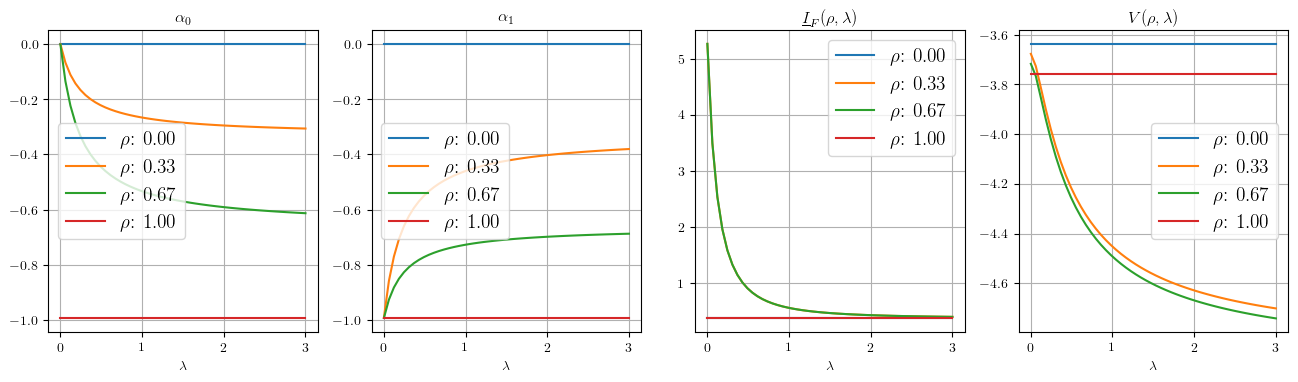

In [5]:
# Plot results
fig, ax = plt.subplots(nrows=1, ncols=4)
titles = [r'$\alpha_0$', r'$\alpha_1$', r'$\underline{I}_F(\rho,\lambda)$', r'$V(\rho,\lambda)$']
for i in range(len(RHO)):
    ax[0].plot(LMBD, A0[i,:], label=r'$\rho$: {:.2f}'.format(RHO[i]))
    ax[1].plot(LMBD, A1[i,:], label=r'$\rho$: {:.2f}'.format(RHO[i]))
    ax[2].plot(LMBD, I[i,:], label=r'$\rho$: {:.2f}'.format(RHO[i]))
    ax[3].plot(LMBD, V[i,:], label=r'$\rho$: {:.2f}'.format(RHO[i]))


for i in range(4):
    ax[i].grid()
    ax[i].legend()
    ax[i].set_xlabel(r'$\lambda$')
    ax[i].set_title(r'{}'.format(titles[i]))
plt.show()

## Solve Utility-Privacy Trade-off using solutions in the paper
In this section we show results using the solutions from the paper.

In [6]:
def compute_alpha(rho, lmbd):
    I = np.identity(n)
    T = (I + (2*rho*(1-rho)/lmbd) * E @ B @ R @ B.T ) @ E
    a0 = -rho * np.linalg.inv(B.T @ T @ B) @ B.T @ E @ F * theta
    a1 = ((2*(1-rho)/lmbd) * R @ B.T @ E @ B + np.identity(m)) @ a0
    return (a0, a1)

In [7]:
A1 = np.zeros((len(RHO), len(LMBD)))
A0 = np.zeros((len(RHO), len(LMBD)))
I = np.zeros((len(RHO), len(LMBD)))
V = np.zeros((len(RHO), len(LMBD)))
for i in range(len(RHO)):
    for j in range(len(LMBD)):
        a0, a1 = compute_alpha(RHO[i], LMBD[j])
        I[i,j] = InformationValue(a0, a1)
        V[i,j] = compute_value(RHO[i], a0, a1)
        A0[i,j], A1[i,j] = a0, a1

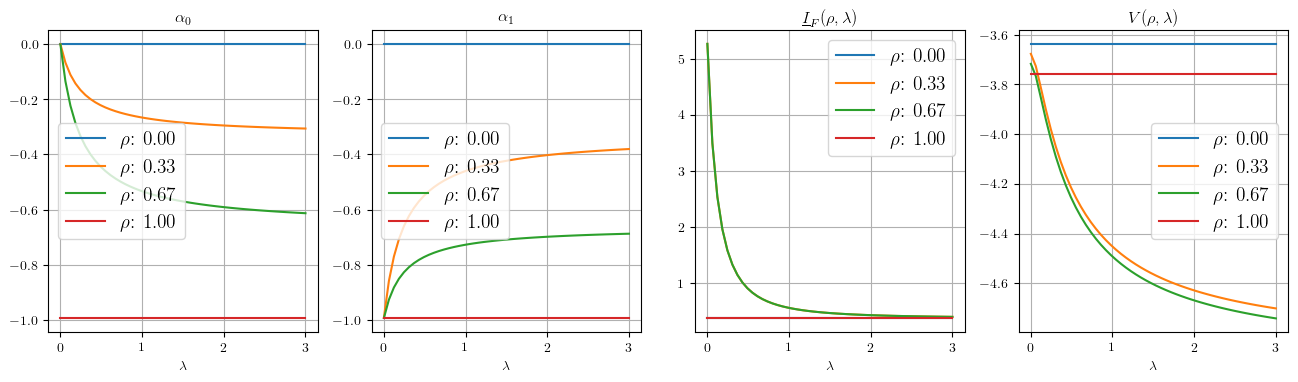

In [8]:
# Plot results
fig, ax = plt.subplots(nrows=1, ncols=4)
titles = [r'$\alpha_0$', r'$\alpha_1$', r'$\underline{I}_F(\rho,\lambda)$', r'$V(\rho,\lambda)$']
for i in range(len(RHO)):
    ax[0].plot(LMBD, A0[i,:], label=r'$\rho$: {:.2f}'.format(RHO[i]))
    ax[1].plot(LMBD, A1[i,:], label=r'$\rho$: {:.2f}'.format(RHO[i]))
    ax[2].plot(LMBD, I[i,:], label=r'$\rho$: {:.2f}'.format(RHO[i]))
    ax[3].plot(LMBD, V[i,:], label=r'$\rho$: {:.2f}'.format(RHO[i]))


for i in range(4):
    ax[i].grid()
    ax[i].legend()
    ax[i].set_xlabel(r'$\lambda$')
    ax[i].set_title(r'{}'.format(titles[i]))
plt.show()

## Contour plots
Contour plots for the best privacy level and the value utility function

In [9]:
# Solve problem for different values of rho and lambda
RHO = np.linspace(0, 1, 100)
LMBD = np.linspace(1e-3, 3, 100)
A1 = np.zeros((len(RHO), len(LMBD)))
A0 = np.zeros((len(RHO), len(LMBD)))
I = np.zeros((len(RHO), len(LMBD)))
V = np.zeros((len(RHO), len(LMBD)))
for i in range(len(RHO)):
    for j in range(len(LMBD)):
        a0, a1 = compute_alpha(RHO[i], LMBD[j])
        I[i,j] = InformationValue(a0, a1)
        V[i,j] = compute_value(RHO[i], a0, a1)
        A0[i,j], A1[i,j] = a0, a1

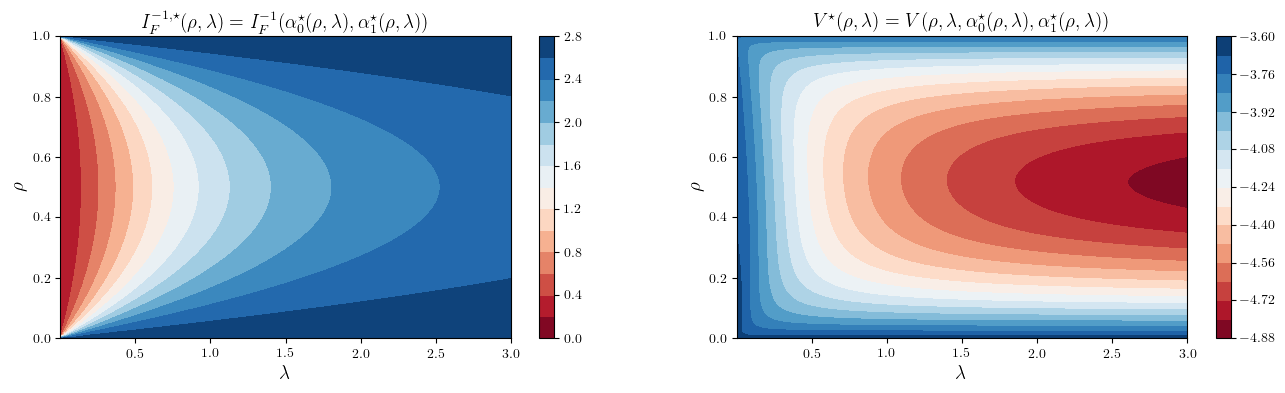

In [10]:
XI, YI = np.meshgrid(LMBD, RHO);

fig, ax = plt.subplots(nrows=1, ncols=2)
z = ax[0].contourf(XI,YI,1/I,levels=15,cmap='RdBu')
ax[0].set_xlabel(r'$\lambda$', fontsize=14)
ax[0].set_ylabel(r'$\rho$', fontsize=14)
ax[0].set_title(r'$I_F^{-1,\star}(\rho,\lambda) = I_F^{-1}(\alpha_0^\star(\rho,\lambda),\alpha_1^\star(\rho,\lambda))$', fontsize=14)
plt.colorbar(z, ax=ax[0])

z = ax[1].contourf(XI,YI,V,levels=15,cmap='RdBu')
ax[1].set_xlabel(r'$\lambda$', fontsize=14)
ax[1].set_ylabel(r'$\rho$', fontsize=14)
ax[1].set_title(r'$V^\star(\rho,\lambda) = V(\rho,\lambda, \alpha_0^\star(\rho,\lambda),\alpha_1^\star(\rho,\lambda))$', fontsize=14)
plt.colorbar(z, ax=ax[1])
plt.show()

## Step plots

In [11]:
def compute_step(A, B, K, F, theta, v, N, alpha0, alpha1, R, Q, enable_privacy=True):
    x = np.zeros(B.shape[0])
    out = np.zeros((N, 1))
    states = np.zeros((N, B.shape[0]))
    inp = np.zeros((N, B.shape[1]))
    gen_noise = lambda x: np.random.multivariate_normal(x, R)
    
    for n in range(N):
        u = K @ x
        if enable_privacy:
            u += gen_noise(alpha0.flatten()) if n < v else gen_noise(alpha1.flatten())
        x = A @ x + B @ u + np.random.multivariate_normal([0] * B.shape[0], Q)
        x += (F * theta).flatten() if n >= v else 0
        states[n, :] = x
        out[n, :] = np.dot(x, x)
        inp[n, :] = u
    return out, inp, states

In [12]:
sims = 1000
rhos = [0., 0.5, 1.]
lmbd = 1.5
N = 50
v = 25

data_out = np.zeros((sims, len(rhos), N, 1))
data_states = np.zeros((sims, len(rhos), N, B.shape[0]))
data_inp = np.zeros((sims, len(rhos), N, B.shape[1]))
data_nopriv_states = np.zeros((sims, N, B.shape[0]))
data_nopriv_out = np.zeros((sims, N, 1))
data_nopriv_inp = np.zeros((sims, N, B.shape[1]))


for s in range(sims):
    out, inp, states = compute_step(A, B, K, F, theta, v, N, 0, 0, 0, Q, enable_privacy=False)
    data_nopriv_out[s, :, :] = out
    data_nopriv_states[s, :, :] = states
    data_nopriv_inp[s, :, :] = inp
    for idx, rho in enumerate(rhos):
        alpha0, alpha1 = compute_alpha(rho, lmbd)
        out, inp, states = compute_step(A, B, K, F, theta, v, N, alpha0, alpha1, R, Q)
        data_out[s, idx, :, :] = out
        data_inp[s, idx, :, :] = inp
        data_states[s, idx, :, :] = states
        
avg_data_out = np.mean(data_out, axis=0)
avg_data_states = np.mean(data_states, axis=0)
avg_data_inp = np.mean(data_inp, axis=0)
avg_data_nopriv_out = np.mean(data_nopriv_out, axis=0)
avg_data_nopriv_inp = np.mean(data_nopriv_inp, axis=0)
avg_data_nopriv_states = np.mean(data_nopriv_states, axis=0)

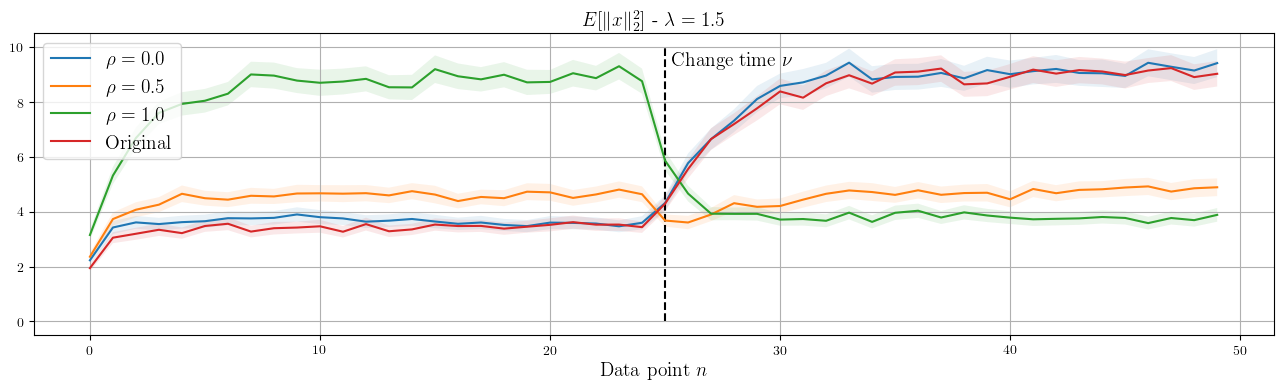

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=1)
x = np.arange(N)

for idx, rho in enumerate(rhos):
    ax.plot(x, avg_data_out[idx, :], label=r'$\rho= {}$'.format(rho))
    c = 1.96 * np.std(data_out, axis=0) / np.sqrt(sims)    
    ax.fill_between(x, (avg_data_out[idx, :] - c[idx, :]).flatten(),
                       (avg_data_out[idx, :] + c[idx, :]).flatten(), alpha=0.1)
    
ax.plot(avg_data_nopriv_out, label='Original')
c = 1.96 * np.std(data_nopriv_out, axis=0) / np.sqrt(sims)    
ax.fill_between(x, (avg_data_nopriv_out - c).flatten(),
                   (avg_data_nopriv_out + c).flatten(), alpha=0.1)
ax.legend()
ax.grid()
ax.set_xlabel(r'Data point $n$', fontsize=14)
ax.set_title(r'$E[\|x\|_2^2]$ - $\lambda=1.5$', fontsize=14)

plt.vlines(v, ymin=0, ymax=10, color = 'k', linestyles='dashed')
plt.text(v+0.3, 9.5, r"Change time $\nu$", rotation=0, verticalalignment='center', fontsize=14)
plt.show()

In [13]:
rho = 1
lmbd = 1
alpha1 = cp.Variable((1, 1))
alpha0 = 0
V = - np.trace(Sigma)
V -= cp.quad_form((B @ alpha1 + F * theta), E)
IF = 0.5 * (c_theta + cp.quad_form((alpha1 - alpha0), Rinv))
problem = cp.Problem(cp.Maximize(V - lmbd * IF), [])
problem.solve()
Z = -np.linalg.inv(lmbd * 0.5 * np.identity(m) + R @ B.T @ E @B) @ R @ B.T @ E @ F * theta
print(Z)
alpha1.value


[[-0.51804011]]


array([[-0.51804011]])